# Predict Future Price

---

### Import Libraries and Dependencies

In [1]:
# Initial imports
import os
import pandas as pd
from pathlib import Path
import datetime as dt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import matplotlib.pyplot as plt
%matplotlib inline

import talib

### Read CSV / API into Pandas DataFrame

In [2]:
# Loading data
# Create a list of all csv files in the data directory
data_dir = "Resources/Data/"
dir_content = os.listdir(data_dir)
data_files = [data_dir + x for x in dir_content if x.lower().endswith('.csv')]
data_files.sort()
data_files

['Resources/Data/AAPL.csv',
 'Resources/Data/AMZN.csv',
 'Resources/Data/BABA.csv',
 'Resources/Data/BTCUSD=X.csv',
 'Resources/Data/EMR.csv',
 'Resources/Data/EURUSD=X.csv',
 'Resources/Data/EXC.csv',
 'Resources/Data/F.csv',
 'Resources/Data/GBPUSD=X.csv',
 'Resources/Data/GOOG.csv',
 'Resources/Data/Gold.csv',
 'Resources/Data/HYG.csv',
 'Resources/Data/JPM.csv',
 'Resources/Data/KO.csv',
 'Resources/Data/LQD.csv',
 'Resources/Data/MMM.csv',
 'Resources/Data/MSCI Europe.csv',
 'Resources/Data/Nikkei Index.csv',
 'Resources/Data/Oil.csv',
 'Resources/Data/PFE.csv',
 'Resources/Data/Russell 2000.csv',
 'Resources/Data/SIEGY.csv',
 'Resources/Data/SPG.csv',
 'Resources/Data/SSNLF.csv',
 'Resources/Data/TSLA.csv']

### Calculate Indicators and Prepare Data

In [3]:
def add_indicators_and_signals(df):

    #df = df.drop(["Adj Close", "Ticker"], axis=1)
    
    if 'High' in df.columns:
        stock_high = df['High']
    else:
        stock_high = None
        
    if 'Low' in df.columns:
        stock_low = df['Low']
    else:
        stock_low = None
            
    if 'Open' in df.columns:
        stock_open = df['Open']
    else:
        stock_open = None
        
    if 'Volume' in df.columns:
        stock_volume = df['Volume']
    else:
        stock_volume = None
        
    if 'Adj Close' in df.columns:
        stock_close = df['Adj Close']
    else:
        stock_close = df['Close']
    
    # MACD, MACD Histogram
    df['MACD'], df['MSIG'], df['MACDH'] = talib.MACD(stock_close, fastperiod=12, slowperiod=26, signalperiod=9)

    # MACD > MSIG: Buy
    # MACD < MSIG: Sell
    df['MACD Sig'] = np.where(df['MACD'] > df['MSIG'], 1, 0) + np.where(df['MACD'] < df['MSIG'], -1, 0)

    # MACD Histogram (MACDH) 
    df['MACDH Sig'] = np.where(df['MACDH'] > 0, 1, 0) + np.where(df['MACDH'] < 0, -1, 0)
    
    # ---------------------------------------------
    
    # Compute Average Directional Index (ADX)
    if stock_low is not None and stock_high is not None:
        df['ADX'] = talib.ADX(stock_high, stock_low, stock_close, timeperiod=14)

        # ADX > 25: Strong Trend Strength 
        # ADX < 20: Weak Trend Strength
        df['ADX Sig'] = np.where(df['ADX'] > 25, 1, 0) + np.where(df['ADX'] < 20, -1, 0)
    
    # ---------------------------------------------
    
    # Compute Relative Strength Index (RSI)
    df['RSI'] = talib.RSI(stock_close, timeperiod=14)

    # RSI < 30: Over sold -> Buy
    # RSI > 70: Over bought -> Sell
    df['RSI Sig'] = np.where(df['RSI'] < 30, 1, 0) + np.where(df['RSI'] > 70, -1, 0)
    
    # ---------------------------------------------
    
    # Compute Bollinger Bands
    df['BB Upper'], df['BB middle'], df['BB Lower'] = talib.BBANDS(stock_close, timeperiod=26)
    df['BB Sig'] = np.where(stock_close < df['BB Lower'], 1, 0) + np.where(stock_close > df['BB Upper'], -1, 0)
    
    # ---------------------------------------------
    
    # Compute Force Index
    if stock_volume is not None:
        #df['FI'] = stock_volume * (stock_close - stock_close.shift(1))
        df['FI'] = stock_volume * stock_close.diff()
        df['EFI'] = talib.EMA(df['FI'], timeperiod=13)

        # Remove Scientific Notation from columns FI and EFI
        pd.options.display.float_format = '{:.2f}'.format

        df['EFI Sig'] = np.where(df['EFI'] > 0, 1, -1)
    
    # ---------------------------------------------
    
    # Calculate 5 day simple movering average
    df['SMA 5'] = stock_close.transform(lambda x: x.rolling(window = 5).mean())

    # Calculate 15 day simple movering average
    df['SMA 15'] = stock_close.transform(lambda x: x.rolling(window = 15).mean())

    # Calculate simple moving average ratio to capture the relationship between the two moving averages
    df['SMA 15/5'] = df['SMA 15'] / df['SMA 5']

    # Calculate Signal for SMA 200/50
    df['SMA 15/5 Sig'] = np.where(df['SMA 5'] > df['SMA 15'], 1.0, 0.0) + np.where(df['SMA 5'] < df['SMA 15'], -1.0, 0.0)
    
    # --------------------------------------------
    
    # Calculate 5 day exp movering average
    df['EMA 5'] = talib.EMA(stock_close, timeperiod=5)

    # Calculate 10 day exp movering average
    df['EMA 15'] = talib.EMA(stock_close, timeperiod=15)

    # Calculate exp moving average ratio to capture the relationship between the two moving averages
    df['EMA 15/5'] = df['EMA 15'] / df['EMA 5']

    # Calculate Signal for SMA 200/50
    df['EMA 15/5 Sig'] = np.where(df['EMA 5'] > df['SMA 15'], 1.0, 0.0) + np.where(df['SMA 5'] < df['SMA 15'], -1.0, 0.0)
    
    ##############################################################
    
    # Calculate daily return
    df['Returns'] = df['Close'].pct_change()
    # Create Target column
    df['Target'] = np.where(df['Returns'] >= 0, 1.0, -1)
    
    # Shift Target column by index -1 (compare today's values with tomorrow's trend)
    df['Target'] = df['Target'].shift(-1)

    # Replacing infinite with nan 
    df.replace([np.inf, -np.inf], np.nan, inplace=True) 

    # Dropping all the rows with nan values 
    df.dropna(inplace=True) 
    
    return df

In [4]:
def random_forest_indicators_only(df, ticker):
    # Define features set
    X = df.copy()
    
    # Drop useless columns
    signal_columns = [col for col in X.columns if col.endswith(' Sig')]
    X.drop(signal_columns, axis=1, inplace=True)
    X.drop(['Ticker', 'Returns', 'Target'], axis=1, inplace=True)

    # Some tickers do not have these indicators
    if 'ADX Sig' in X.columns:
        X.drop('ADX Sig', axis=1, inplace=True)

    if 'EFI Sig' in X.columns:
        X.drop('EFI Sig', axis=1, inplace=True)
    
    # Define target vector
    y = df["Target"].ravel()
    
    # Splitting into Train and Test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)
    
    # Creating StandardScaler instance
    scaler = StandardScaler()
    
    # Fitting Standard Scaller
    X_scaler = scaler.fit(X_train)
    
    # Scaling data
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    
    # Create a random forest classifier
    rf_model = RandomForestClassifier(n_estimators=500, random_state=1)
    
    # Fitting the model
    rf_model = rf_model.fit(X_train_scaled, y_train)
    
    # Making predictions using the testing data
    predictions = rf_model.predict(X_test_scaled)
    
    # Calculating the confusion matrix
    cm = confusion_matrix(y_test, predictions)
    cm_df = pd.DataFrame(
        cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
    )

    # Calculating the accuracy score
    acc_score = accuracy_score(y_test, predictions)
    
    # Displaying results
    print(f'\n{ticker}: Confusion Matrix (Indicators Only, No Signals)')
    display(cm_df)
    print(f"Accuracy Score : {acc_score}")
    print("Classification Report")
    print(classification_report(y_test, predictions))
    
    return rf_model, X.columns, acc_score

In [5]:
def random_forest_signals_only(df, ticker):
    # Define features set
    X = df.copy()
    
    # Only keep signal columns
    column_to_keep = [col for col in X.columns if col.endswith(' Sig')]
    X = X[column_to_keep]
    
    # Define target vector
    y = df["Target"].ravel()
    
    # Splitting into Train and Test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)
    
    # Creating StandardScaler instance
    scaler = StandardScaler()
    
    # Fitting Standard Scaller
    X_scaler = scaler.fit(X_train)
    
    # Scaling data
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    
    # Create a random forest classifier
    rf_model = RandomForestClassifier(n_estimators=500, random_state=1)
    
    # Fitting the model
    rf_model = rf_model.fit(X_train_scaled, y_train)
    
    # Making predictions using the testing data
    predictions = rf_model.predict(X_test_scaled)
    
    # Calculating the confusion matrix
    cm = confusion_matrix(y_test, predictions)
    cm_df = pd.DataFrame(
        cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
    )

    # Calculating the accuracy score
    acc_score = accuracy_score(y_test, predictions)
    
    # Displaying results
    print(f'\n{ticker}: Confusion Matrix (Signals Only, No Indicators)')
    display(cm_df)
    print(f"Accuracy Score : {acc_score}")
    print("Classification Report")
    print(classification_report(y_test, predictions))
    
    return rf_model, X.columns, acc_score

In [6]:
def features_importances(ticker, rf_model, X_columns):
    # Random Forests in sklearn will automatically calculate feature importance
    importances = rf_model.feature_importances_
    
    # We can sort the features by their importance
    sorted(zip(rf_model.feature_importances_, X_columns), reverse=True)
    
    # Visualize the features by importance
    importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X_columns), reverse=True))
    importances_df.set_index(importances_df[1], inplace=True)
    importances_df.drop(columns=1, inplace=True)
    importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
    importances_sorted = importances_df.sort_values(by='Feature Importances')
    
    chart = importances_sorted.plot(kind='barh', color='lightgreen', title= f'{ticker} Features Importances', legend=False) 
    plt.show()
    plt.close()
    return chart


### Run the Random Forest Model for only 1 ticker


AAPL: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,165,178
Actual 1,179,223


Accuracy Score : 0.5208053691275167
Classification Report
              precision    recall  f1-score   support

        -1.0       0.48      0.48      0.48       343
         1.0       0.56      0.55      0.56       402

    accuracy                           0.52       745
   macro avg       0.52      0.52      0.52       745
weighted avg       0.52      0.52      0.52       745



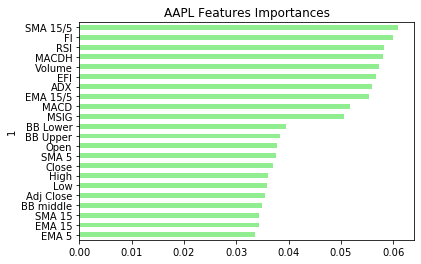


AAPL: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,149,194
Actual 1,170,232


Accuracy Score : 0.5114093959731544
Classification Report
              precision    recall  f1-score   support

        -1.0       0.47      0.43      0.45       343
         1.0       0.54      0.58      0.56       402

    accuracy                           0.51       745
   macro avg       0.51      0.51      0.51       745
weighted avg       0.51      0.51      0.51       745



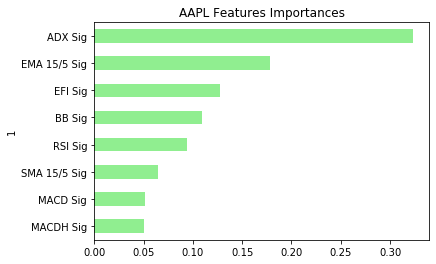

In [7]:
file_path = Path("Resources/Data/AAPL.csv")
df = pd.read_csv(file_path, index_col="Date")
ticker = df.Ticker.unique().tolist()[0]

# Calculate indicators and prepare data
df = add_indicators_and_signals(df)

# Make predictions using indicator values only and display confusion matrix
rf_model, X_columns, tmp_acc = random_forest_indicators_only(df, ticker)

# Display importance features graph
features_importances(ticker, rf_model, X_columns)

# Make predictions using signals only and display confusion matrix
rf_model, X_columns, tmp_acc = random_forest_signals_only(df, ticker)

# Display importance features graph
features_importances(ticker, rf_model, X_columns)

### Run the Random Forest Model for All the Data Files in the 'Resources/Data Folder'


----------------------- AAPL -----------------------


AAPL: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,165,178
Actual 1,179,223


Accuracy Score : 0.5208053691275167
Classification Report
              precision    recall  f1-score   support

        -1.0       0.48      0.48      0.48       343
         1.0       0.56      0.55      0.56       402

    accuracy                           0.52       745
   macro avg       0.52      0.52      0.52       745
weighted avg       0.52      0.52      0.52       745



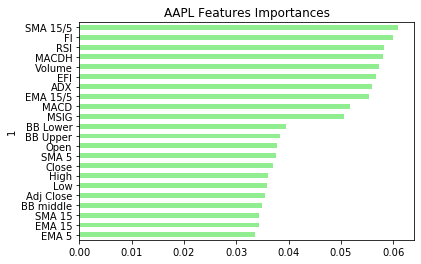

-----


AAPL: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,149,194
Actual 1,170,232


Accuracy Score : 0.5114093959731544
Classification Report
              precision    recall  f1-score   support

        -1.0       0.47      0.43      0.45       343
         1.0       0.54      0.58      0.56       402

    accuracy                           0.51       745
   macro avg       0.51      0.51      0.51       745
weighted avg       0.51      0.51      0.51       745



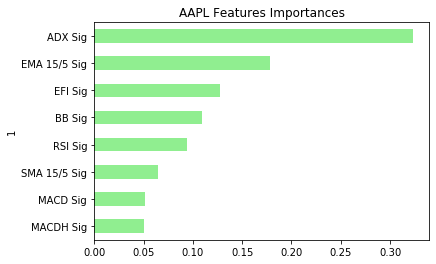


----------------------- AMZN -----------------------


AMZN: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,161,180
Actual 1,166,238


Accuracy Score : 0.5355704697986577
Classification Report
              precision    recall  f1-score   support

        -1.0       0.49      0.47      0.48       341
         1.0       0.57      0.59      0.58       404

    accuracy                           0.54       745
   macro avg       0.53      0.53      0.53       745
weighted avg       0.53      0.54      0.53       745



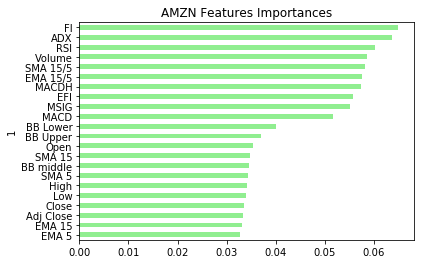

-----


AMZN: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,126,215
Actual 1,139,265


Accuracy Score : 0.5248322147651007
Classification Report
              precision    recall  f1-score   support

        -1.0       0.48      0.37      0.42       341
         1.0       0.55      0.66      0.60       404

    accuracy                           0.52       745
   macro avg       0.51      0.51      0.51       745
weighted avg       0.52      0.52      0.52       745



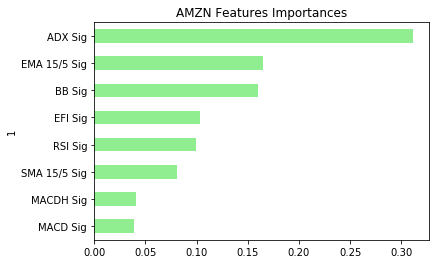


----------------------- BABA -----------------------


BABA: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,89,97
Actual 1,76,127


Accuracy Score : 0.5552699228791774
Classification Report
              precision    recall  f1-score   support

        -1.0       0.54      0.48      0.51       186
         1.0       0.57      0.63      0.59       203

    accuracy                           0.56       389
   macro avg       0.55      0.55      0.55       389
weighted avg       0.55      0.56      0.55       389



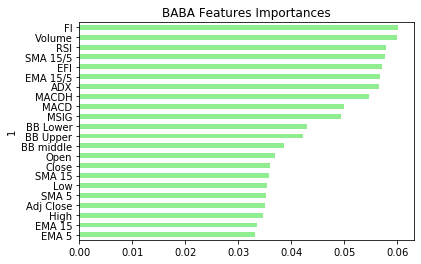

-----


BABA: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,83,103
Actual 1,98,105


Accuracy Score : 0.4832904884318766
Classification Report
              precision    recall  f1-score   support

        -1.0       0.46      0.45      0.45       186
         1.0       0.50      0.52      0.51       203

    accuracy                           0.48       389
   macro avg       0.48      0.48      0.48       389
weighted avg       0.48      0.48      0.48       389



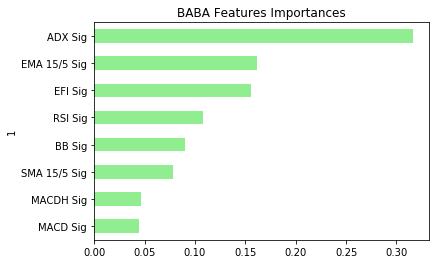


----------------------- BTCUSD=X -----------------------


BTCUSD=X: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,151,178
Actual 1,158,243


Accuracy Score : 0.5397260273972603
Classification Report
              precision    recall  f1-score   support

        -1.0       0.49      0.46      0.47       329
         1.0       0.58      0.61      0.59       401

    accuracy                           0.54       730
   macro avg       0.53      0.53      0.53       730
weighted avg       0.54      0.54      0.54       730



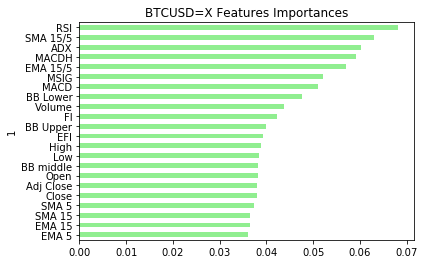

-----


BTCUSD=X: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,98,231
Actual 1,113,288


Accuracy Score : 0.5287671232876713
Classification Report
              precision    recall  f1-score   support

        -1.0       0.46      0.30      0.36       329
         1.0       0.55      0.72      0.63       401

    accuracy                           0.53       730
   macro avg       0.51      0.51      0.49       730
weighted avg       0.51      0.53      0.51       730



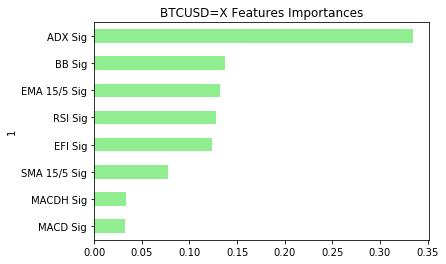


----------------------- EMR -----------------------


EMR: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,155,198
Actual 1,157,235


Accuracy Score : 0.5234899328859061
Classification Report
              precision    recall  f1-score   support

        -1.0       0.50      0.44      0.47       353
         1.0       0.54      0.60      0.57       392

    accuracy                           0.52       745
   macro avg       0.52      0.52      0.52       745
weighted avg       0.52      0.52      0.52       745



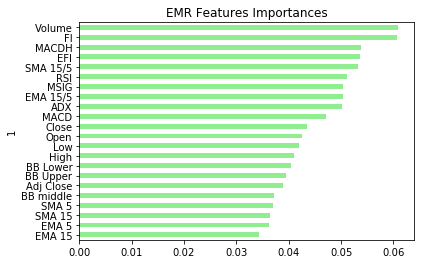

-----


EMR: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,61,292
Actual 1,67,325


Accuracy Score : 0.5181208053691275
Classification Report
              precision    recall  f1-score   support

        -1.0       0.48      0.17      0.25       353
         1.0       0.53      0.83      0.64       392

    accuracy                           0.52       745
   macro avg       0.50      0.50      0.45       745
weighted avg       0.50      0.52      0.46       745



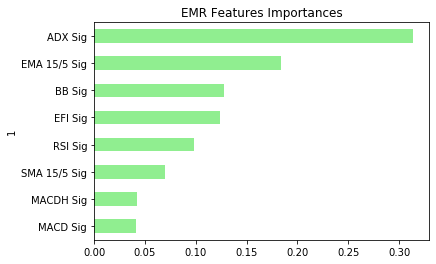


----------------------- EURUSD=X -----------------------


EURUSD=X: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,220,169
Actual 1,168,208


Accuracy Score : 0.5594771241830065
Classification Report
              precision    recall  f1-score   support

        -1.0       0.57      0.57      0.57       389
         1.0       0.55      0.55      0.55       376

    accuracy                           0.56       765
   macro avg       0.56      0.56      0.56       765
weighted avg       0.56      0.56      0.56       765



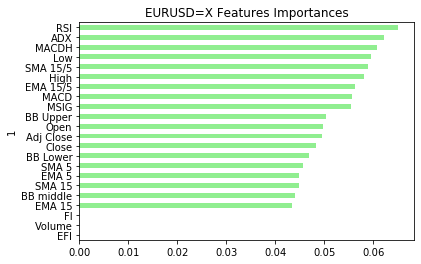

-----


EURUSD=X: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,150,239
Actual 1,157,219


Accuracy Score : 0.4823529411764706
Classification Report
              precision    recall  f1-score   support

        -1.0       0.49      0.39      0.43       389
         1.0       0.48      0.58      0.53       376

    accuracy                           0.48       765
   macro avg       0.48      0.48      0.48       765
weighted avg       0.48      0.48      0.48       765



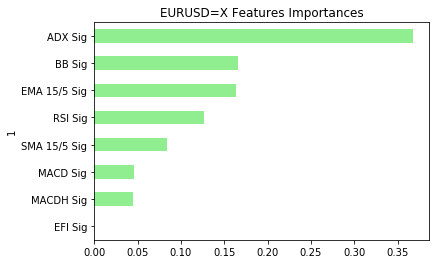


----------------------- EXC -----------------------


EXC: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,182,170
Actual 1,163,230


Accuracy Score : 0.553020134228188
Classification Report
              precision    recall  f1-score   support

        -1.0       0.53      0.52      0.52       352
         1.0       0.57      0.59      0.58       393

    accuracy                           0.55       745
   macro avg       0.55      0.55      0.55       745
weighted avg       0.55      0.55      0.55       745



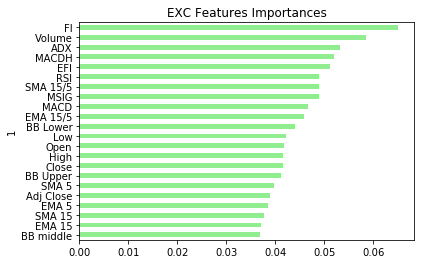

-----


EXC: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,120,232
Actual 1,143,250


Accuracy Score : 0.4966442953020134
Classification Report
              precision    recall  f1-score   support

        -1.0       0.46      0.34      0.39       352
         1.0       0.52      0.64      0.57       393

    accuracy                           0.50       745
   macro avg       0.49      0.49      0.48       745
weighted avg       0.49      0.50      0.49       745



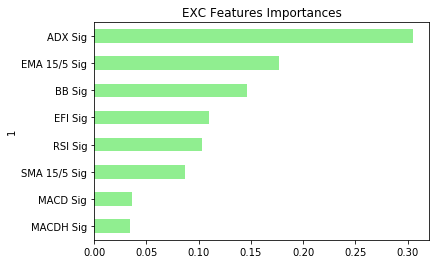


----------------------- F -----------------------


F: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,176,160
Actual 1,206,203


Accuracy Score : 0.508724832214765
Classification Report
              precision    recall  f1-score   support

        -1.0       0.46      0.52      0.49       336
         1.0       0.56      0.50      0.53       409

    accuracy                           0.51       745
   macro avg       0.51      0.51      0.51       745
weighted avg       0.51      0.51      0.51       745



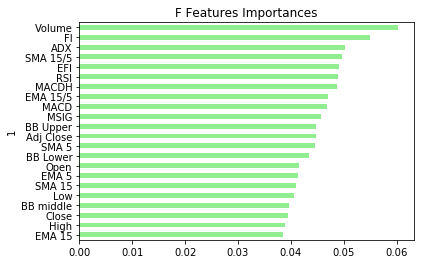

-----


F: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,112,224
Actual 1,126,283


Accuracy Score : 0.5302013422818792
Classification Report
              precision    recall  f1-score   support

        -1.0       0.47      0.33      0.39       336
         1.0       0.56      0.69      0.62       409

    accuracy                           0.53       745
   macro avg       0.51      0.51      0.50       745
weighted avg       0.52      0.53      0.52       745



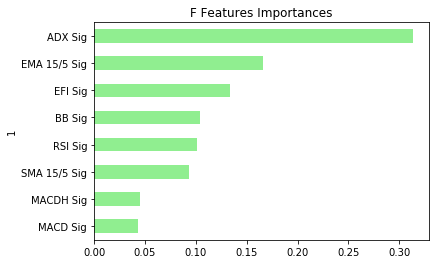


----------------------- GBPUSD=X -----------------------


GBPUSD=X: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,223,159
Actual 1,178,205


Accuracy Score : 0.5594771241830065
Classification Report
              precision    recall  f1-score   support

        -1.0       0.56      0.58      0.57       382
         1.0       0.56      0.54      0.55       383

    accuracy                           0.56       765
   macro avg       0.56      0.56      0.56       765
weighted avg       0.56      0.56      0.56       765



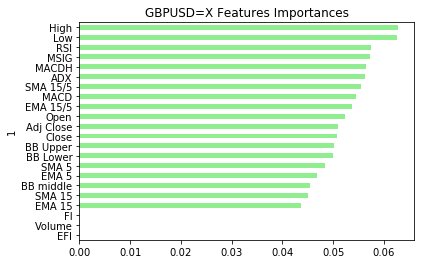

-----


GBPUSD=X: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,197,185
Actual 1,188,195


Accuracy Score : 0.5124183006535947
Classification Report
              precision    recall  f1-score   support

        -1.0       0.51      0.52      0.51       382
         1.0       0.51      0.51      0.51       383

    accuracy                           0.51       765
   macro avg       0.51      0.51      0.51       765
weighted avg       0.51      0.51      0.51       765



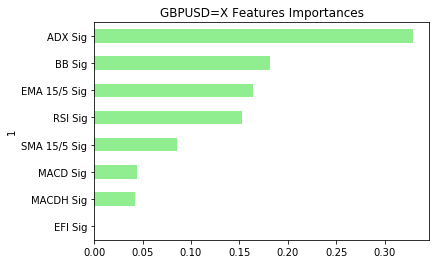


----------------------- GOOG -----------------------


GOOG: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,182,157
Actual 1,195,211


Accuracy Score : 0.5275167785234899
Classification Report
              precision    recall  f1-score   support

        -1.0       0.48      0.54      0.51       339
         1.0       0.57      0.52      0.55       406

    accuracy                           0.53       745
   macro avg       0.53      0.53      0.53       745
weighted avg       0.53      0.53      0.53       745



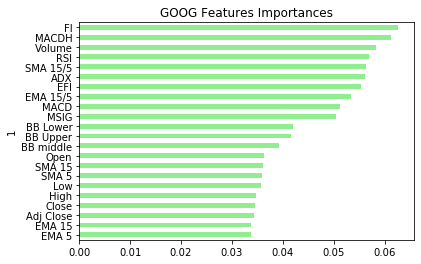

-----


GOOG: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,177,162
Actual 1,214,192


Accuracy Score : 0.49530201342281877
Classification Report
              precision    recall  f1-score   support

        -1.0       0.45      0.52      0.48       339
         1.0       0.54      0.47      0.51       406

    accuracy                           0.50       745
   macro avg       0.50      0.50      0.50       745
weighted avg       0.50      0.50      0.50       745



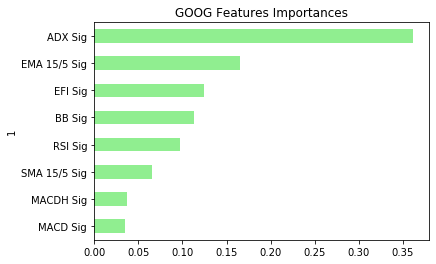


----------------------- Gold -----------------------


Gold: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,177,205
Actual 1,161,202


Accuracy Score : 0.508724832214765
Classification Report
              precision    recall  f1-score   support

        -1.0       0.52      0.46      0.49       382
         1.0       0.50      0.56      0.52       363

    accuracy                           0.51       745
   macro avg       0.51      0.51      0.51       745
weighted avg       0.51      0.51      0.51       745



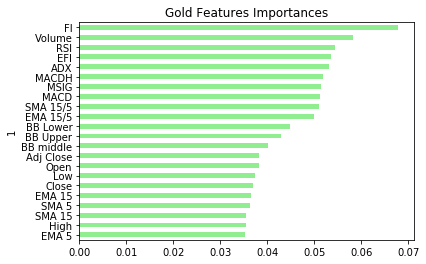

-----


Gold: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,119,263
Actual 1,99,264


Accuracy Score : 0.5140939597315436
Classification Report
              precision    recall  f1-score   support

        -1.0       0.55      0.31      0.40       382
         1.0       0.50      0.73      0.59       363

    accuracy                           0.51       745
   macro avg       0.52      0.52      0.49       745
weighted avg       0.52      0.51      0.49       745



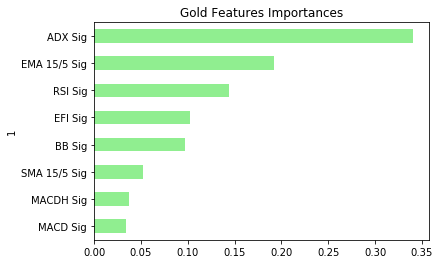


----------------------- HYG -----------------------


HYG: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,166,183
Actual 1,159,237


Accuracy Score : 0.5409395973154363
Classification Report
              precision    recall  f1-score   support

        -1.0       0.51      0.48      0.49       349
         1.0       0.56      0.60      0.58       396

    accuracy                           0.54       745
   macro avg       0.54      0.54      0.54       745
weighted avg       0.54      0.54      0.54       745



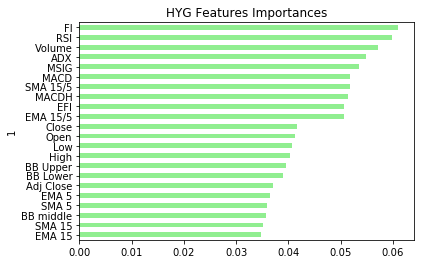

-----


HYG: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,93,256
Actual 1,100,296


Accuracy Score : 0.5221476510067115
Classification Report
              precision    recall  f1-score   support

        -1.0       0.48      0.27      0.34       349
         1.0       0.54      0.75      0.62       396

    accuracy                           0.52       745
   macro avg       0.51      0.51      0.48       745
weighted avg       0.51      0.52      0.49       745



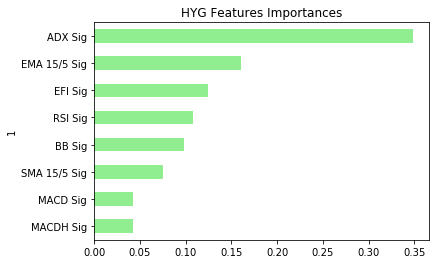


----------------------- JPM -----------------------


JPM: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,161,181
Actual 1,198,205


Accuracy Score : 0.4912751677852349
Classification Report
              precision    recall  f1-score   support

        -1.0       0.45      0.47      0.46       342
         1.0       0.53      0.51      0.52       403

    accuracy                           0.49       745
   macro avg       0.49      0.49      0.49       745
weighted avg       0.49      0.49      0.49       745



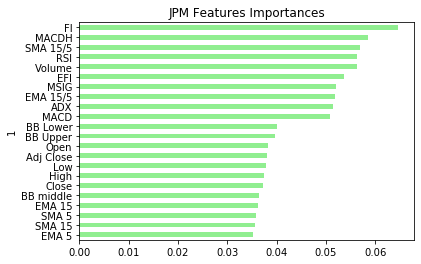

-----



In [ ]:
counter = 0
ind_accuracy = 0
sig_accuracy = 0

for file in data_files:
    tmp_df = pd.read_csv(Path(file), index_col="Date")
    ticker = tmp_df.Ticker.unique().tolist()[0]
    
    # To run for a specific category just uncomment one of these lines and fix the identation
#     if ticker in ['Gold', 'Oil']: # Commodity
#     if ticker in ['EURUSD=X', 'GBPUSD=X', 'BTCUSD=X']: # Currency
#     if ticker in ['Russell 2000']: # Small Cap
#     if ticker in ['LQD', 'HYG']: # Bonds
#     if ticker in ['BABA', 'MSCI Europe', 'Nikkei Index', 'SSNLF', 'SIEGY']: #Foreign Equity
#     if ticker in ['AAPL', 'AMZN', 'EMR', 'EXC', 'F', 'GOOG', 'JPM', 'KO', 'MMM', 'PFE', 'SPG', 'TSLA']: # Domestic Equity
        
    print(f'\n----------------------- {ticker} -----------------------\n')

    # Calculate indicators and prepare data
    tmp_df = add_indicators_and_signals(tmp_df)

    # Use only the indicator values, no signals
    # Make predictions and display confusion matrix
    log_reg_model, X_columns, tmp_acc = random_forest_indicators_only(tmp_df, ticker)
    ind_accuracy = ind_accuracy + tmp_acc

    # Display importance features graph
    features_importances(ticker, log_reg_model, X_columns)

    print("-----\n")

    # Use only the signal values no indicator values
    # Make predictions and display confusion matrix
    log_reg_model, X_columns, tmp_acc = random_forest_signals_only(tmp_df, ticker)
    sig_accuracy = sig_accuracy + tmp_acc

    # Display importance features graph
    features_importances(ticker, log_reg_model, X_columns)

    counter = counter + 1

print("\n------------------------------------------------\nAccuracy Averages:")
print(f'Indicators Only Accuracy Average: {ind_accuracy/counter}')
print(f'Signals Only Accuracy Average: {sig_accuracy/counter}')
print(f'Counter:{counter}')